# ROMY Barometer - Statistic Plots

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from obspy import read_inventory

from andbro__read_sds import __read_sds

In [2]:
from functions.get_mean_promy_pressure import __get_mean_promy_pressure
from functions.get_mean_rmy_pressure import __get_mean_rmy_pressure

In [3]:
#%matplotlib tk

In [10]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [11]:
config = {}

# output path for figures
config['path_to_figs'] = data_path+"romy_baro/figures/"

# path to data archive
config['path_to_data'] = data_path+"romy_baro/data/"



## Load Data

In [12]:
df = pd.read_pickle(config['path_to_data']+"RB_statistics.pkl")

In [13]:
df = df[df.status == False]

In [14]:
df.keys()

Index(['t1', 't2', 'status', 'shift_PP_N', 'shift_PP_E', 'shift_HP_N',
       'shift_HP_E', 'cmax_PP_N', 'cmax_PP_E', 'cmax_HP_N', 'cmax_HP_E', 'r_z',
       'r_n', 'r_e', 'a_z', 'a_n', 'a_e', 'b_z', 'b_n', 'b_e'],
      dtype='object')

In [15]:
for k in ["shift_PP_N", "shift_PP_E", "shift_HP_N", "shift_HP_E"]:
    df[k] = df[k]/20 # 20 Hz sampling rate


In [16]:
df = df[df.b_e != 0]

In [17]:
df

,t1,t2,status,shift_PP_N,shift_PP_E,shift_HP_N,shift_HP_E,cmax_PP_N,cmax_PP_E,cmax_HP_N,cmax_HP_E,r_z,r_n,r_e,a_z,a_n,a_e,b_z,b_n,b_e
0,2024-06-01T00:00:00.000000Z,2024-06-01T02:00:00.000000Z,False,-4689.50,-4689.75,-4195.90,-4196.50,-0.689838,0.681541,-0.692942,0.683491,2.44,1.65,2.44,6.108248e-09,-5.927710e-09,-3.671448e-09,1.965910e-08,-1.041630e-09,-1.212135e-08
1,2024-06-01T01:30:00.000000Z,2024-06-01T03:30:00.000000Z,False,-142.55,-142.45,-465.05,-464.95,0.942927,-0.942541,-0.742501,0.742230,80.02,79.25,79.19,5.684086e-08,2.005669e-08,-3.475087e-08,2.412910e-08,8.536555e-09,-1.477305e-08
2,2024-06-01T03:00:00.000000Z,2024-06-01T05:00:00.000000Z,False,-5654.40,-5623.85,-5253.75,-5228.10,-0.528884,0.469836,-0.547310,0.491795,0.74,3.00,2.84,-3.248622e-10,1.172245e-10,-1.559857e-10,-1.954800e-10,-3.509496e-10,5.073208e-10
3,2024-06-01T04:30:00.000000Z,2024-06-01T06:30:00.000000Z,False,-5075.15,-4362.90,-4694.90,-4695.35,0.672672,0.673088,0.756154,-0.755201,0.04,0.07,0.05,-2.392756e-09,-9.822519e-10,1.544245e-09,-1.855930e-10,-4.313552e-10,3.242136e-10
4,2024-06-01T06:00:00.000000Z,2024-06-01T08:00:00.000000Z,False,-457.50,-457.10,-79.55,-79.70,-0.741622,0.740167,-0.917536,0.917370,81.60,81.62,81.63,1.147091e-08,4.034340e-09,-7.018953e-09,-3.286694e-08,-1.169564e-08,2.019354e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,2024-06-29T07:30:00.000000Z,2024-06-29T09:30:00.000000Z,False,-2277.25,-11.55,-2562.40,-5442.70,0.560011,-0.485524,-0.485189,0.456749,0.13,20.94,24.15,3.340225e-13,1.317321e-10,-9.232846e-11,-8.227704e-13,1.657721e-11,-8.489125e-12
454,2024-06-29T09:00:00.000000Z,2024-06-29T11:00:00.000000Z,False,-2090.55,-2089.75,-1702.75,-1706.45,-0.623407,0.597140,-0.584913,0.582504,12.55,7.32,12.94,3.349430e-12,2.367277e-12,6.752089e-13,1.493157e-11,-1.161701e-10,8.056582e-11
460,2024-06-29T18:00:00.000000Z,2024-06-29T20:00:00.000000Z,False,-4894.65,-5302.60,-5191.45,-5551.30,-0.632743,-0.595747,0.633282,0.712729,0.31,0.15,1.27,1.409219e-12,4.267640e-12,-2.037710e-12,2.958645e-12,1.632432e-12,-1.046628e-11
461,2024-06-29T19:30:00.000000Z,2024-06-29T21:30:00.000000Z,False,-4387.60,-4085.75,-4658.20,-3785.35,-0.709273,0.658496,0.713792,0.649777,8.26,0.54,0.09,-8.185552e-12,4.503353e-11,2.260960e-10,9.255556e-12,5.779821e-14,4.796043e-10


In [18]:
# select only those with VR > 50 %
# df2 = df[(df.r_z > 50) & (df.r_n > 50) & (df.r_e > 50)]

# select only those with CC > 0.7
dfN = df[(df.cmax_PP_N > 0.7) | (df.cmax_HP_N > 0.7)]
dfE = df[(df.cmax_PP_E > 0.7) | (df.cmax_HP_E > 0.7)]
dfZ = df[(df.cmax_PP_Z > 0.7) | (df.cmax_HP_Z > 0.7)]


AttributeError: 'DataFrame' object has no attribute 'cmax_PP_Z'

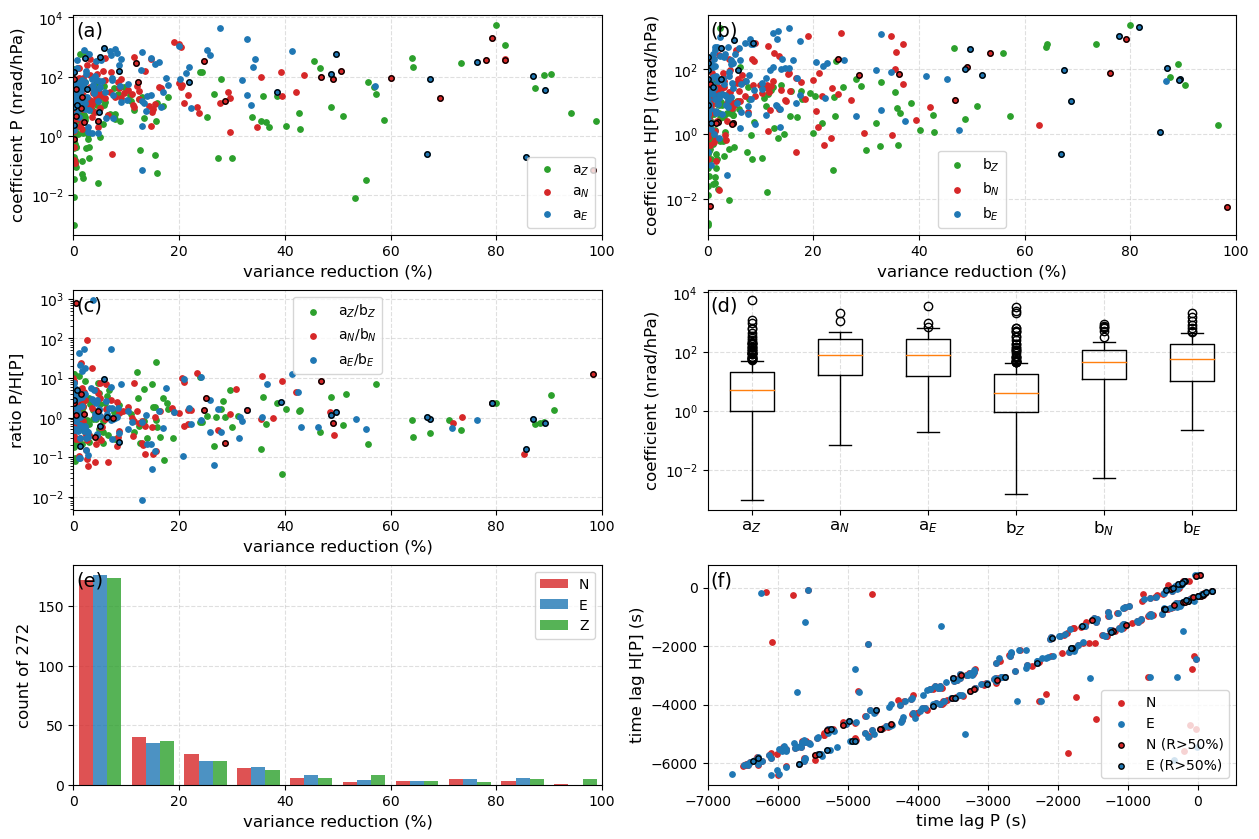

In [19]:
def __makeplot():

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    colors = {"Z":"tab:green", "N":"tab:red", "E":"tab:blue"}

    Nrow, Ncol = 3, 2

    font = 12

    scale, unit = 1e11, "nrad/hPa"

    hil = r"H[P]"

    fig = plt.figure(figsize=(15, 10))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.25)

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 0])
    ax5 = fig.add_subplot(gs[2, 1])

    # ___________________________________________________
    ax0.scatter(df.r_z, df.a_z*scale, s=15, color=colors["Z"], label=r"a$_Z$", zorder=2)
    ax0.scatter(df.r_n, df.a_n*scale, s=15, color=colors["N"], label=r"a$_N$", zorder=2)
    ax0.scatter(df.r_e, df.a_e*scale, s=15, color=colors["E"], label=r"a$_E$", zorder=2)
    # ax0.scatter(df2.r_z, df2.a_z*scale, s=15, color=colors["Z"], zorder=2, edgecolor="k")
    ax0.scatter(dfN.r_n, dfN.a_n*scale, s=15, color=colors["N"], zorder=2, edgecolor="k")
    ax0.scatter(dfE.r_e, dfE.a_e*scale, s=15, color=colors["E"], zorder=2, edgecolor="k")
    ax0.legend(fontsize=font-2)
    ax0.set_yscale("log")
    ax0.set_xlim(0, 100)
    ax0.set_xlabel(f"variance reduction (%)", fontsize=font)
    ax0.set_ylabel(f"coefficient P ({unit})", fontsize=font)

    # ___________________________________________________
    ax1.scatter(df.r_z, df.b_z*scale, s=15, color=colors["Z"], label=r"b$_Z$", zorder=2)
    ax1.scatter(df.r_n, df.b_n*scale, s=15, color=colors["N"], label=r"b$_N$", zorder=2)
    ax1.scatter(df.r_e, df.b_e*scale, s=15, color=colors["E"], label=r"b$_E$", zorder=2)
    # ax1.scatter(df2.r_z, df2.b_z*scale, s=15, color=colors["Z"], zorder=2, edgecolor="k")
    ax1.scatter(dfN.r_n, dfN.b_n*scale, s=15, color=colors["N"], zorder=2, edgecolor="k")
    ax1.scatter(dfE.r_e, dfE.b_e*scale, s=15, color=colors["E"], zorder=2, edgecolor="k")
    ax1.legend(fontsize=font-2)
    ax1.set_yscale("log")
    ax1.set_xlim(0, 100)
    ax1.set_xlabel(f"variance reduction (%)", fontsize=font)
    ax1.set_ylabel(f"coefficient {hil} ({unit})", fontsize=font)

    # ___________________________________________________
    ax2.scatter(df.r_z, (df.a_z*scale)/(df.b_z*scale), s=15, color=colors["Z"], label=r"a$_Z$/b$_Z$", zorder=2)
    ax2.scatter(df.r_n, (df.a_n*scale)/(df.b_n*scale), s=15, color=colors["N"], label=r"a$_N$/b$_N$", zorder=2)
    ax2.scatter(df.r_e, (df.a_e*scale)/(df.b_e*scale), s=15, color=colors["E"], label=r"a$_E$/b$_E$", zorder=2)
    # ax2.scatter(df2.r_z, (df2.a_z*scale)/(df2.b_z*scale), s=15, color=colors["Z"], zorder=2, edgecolor="k")
    ax2.scatter(dfN.r_n, (dfN.a_n*scale)/(dfN.b_n*scale), s=15, color=colors["N"], zorder=2, edgecolor="k")
    ax2.scatter(dfE.r_e, (dfE.a_e*scale)/(dfE.b_e*scale), s=15, color=colors["E"], zorder=2, edgecolor="k")
    ax2.legend(fontsize=font-2)
    # ax2.set_ylim(-2, 2)
    ax2.set_xlim(0, 100)
    ax2.set_yscale("log")
    ax2.set_xlabel(f"variance reduction (%)", fontsize=font)
    ax2.set_ylabel(f"ratio P/{hil}", fontsize=font)

    # ___________________________________________________
    # ax3.boxplot([abs(df.a_z*scale), abs(df.a_n*scale), abs(df.a_e*scale), abs(df.b_z*scale), abs(df.b_n*scale), abs(df.b_e*scale)],)
    ax3.boxplot([abs(df.a_z*scale), abs(dfN.a_n*scale), abs(dfE.a_e*scale), abs(df.b_z*scale), abs(dfN.b_n*scale), abs(dfE.b_e*scale)],)
    ax3.set_yscale("log")
    ax3.set_xticklabels([r"a$_Z$", r"a$_N$", r"a$_E$", r"b$_Z$", r"b$_N$", r"b$_E$"], fontsize=font)
    ax3.set_ylabel(f"coefficient ({unit})", fontsize=font)

    # ___________________________________________________
    ax4.hist([df.r_n, df.r_e, df.r_z], bins=10, range=[0, 100], alpha=0.8,
             rwidth=0.8, align="mid", density=False, zorder=2,
             color=[colors["N"], colors["E"], colors["Z"]], label=["N","E","Z"],
            )
    ax4.grid(alpha=0.2, ls="--", zorder=0)
    ax4.set_xlim(0, 100)
    ax4.legend(fontsize=font-2)
    ax4.set_xlabel(f"variance reduction (%)", fontsize=font)
    ax4.set_ylabel(f"count of {df.shape[0]}", fontsize=font)

    # ___________________________________________________
    # ax5.scatter(df.r_z, df.a_z, color=colors["Z"], label=r"b$_Z$", zorder=2)
    ax5.scatter(df.shift_PP_N, df.shift_HP_N, s=15, color=colors["N"], label=r"N", zorder=2)
    ax5.scatter(df.shift_PP_E, df.shift_HP_E, s=15, color=colors["E"], label=r"E", zorder=2)
    ax5.scatter(dfN.shift_PP_N, dfN.shift_HP_N, s=15, color=colors["N"], label=r"N (R>50%)", zorder=2, edgecolor="k")
    ax5.scatter(dfE.shift_PP_E, dfE.shift_HP_E, s=15, color=colors["E"], label=r"E (R>50%)", zorder=2, edgecolor="k")
    ax5.legend(fontsize=font-2, loc=4)
    # ax5.set_ylim(-2, 2)
    # ax5.set_xlim(0, 100)
    ax5.set_xlabel(f"time lag P (s)", fontsize=font)
    ax5.set_ylabel(f"time lag {hil} (s)", fontsize=font)

    ax0.text(.005, .97,"(a)", ha='left', va='top', transform=ax0.transAxes, fontsize=font+2)
    ax1.text(.005, .97,"(b)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97,"(c)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97,"(d)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97,"(e)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)
    ax5.text(.005, .97,"(f)", ha='left', va='top', transform=ax5.transAxes, fontsize=font+2)


    axes = [ax0, ax1, ax2, ax3, ax4, ax5]
    for ax in axes:
        ax.grid(ls="--", alpha=0.4, zorder=0)


    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"RB_statistic_plots.png", format="png", dpi=150, bbox_inches='tight')
